# 7-1. 프로젝트: 한국어 데이터로 챗봇 만들기
# 2024.8.23
# 16:14 ~ 22:00
# 8:00 ~ 12:00
# 구태훈

Step 1. 데이터 수집하기

한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

print(tf.__version__)

# 데이터 파일 경로
file_path = '/content/drive/MyDrive/Colab Notebooks/DS2/NLP/20240823/ChatbotData .csv'

# CSV 파일 읽기
data = pd.read_csv(file_path)

# 데이터 확인
print(data.head())
print(data.shape)

2.17.0
                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0
(11823, 3)


Step 2. 데이터 전처리하기

영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.



전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .
질문의 최대 길이 : 16
답변의 최대 길이 : 24


<ipython-input-7-3047eba0fee2>:36: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from current font.
  plt.tight_layout()
<ipython-input-7-3047eba0fee2>:36: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from current font.
  plt.tight_layout()
<ipython-input-7-3047eba0fee2>:36: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
<ipython-input-7-3047eba0fee2>:36: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  plt.tight_layout()
<ipython-input-7-3047eba0fee2>:36: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from current font.
  plt.tight_layout()
<ipython-input-7-3047eba0fee2>:36: UserWarning: Glyph 51656 (\N{HANGUL SYLLABLE JIL}) missing from current font.
  plt.tight_layout()
<ipython-input-7-3047eba0fee2>:36: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from current font.
  plt.tight_layout()
<ipython-input-7-3047eba0fee2>:36: UserWarning: Glyph 51060 (\N

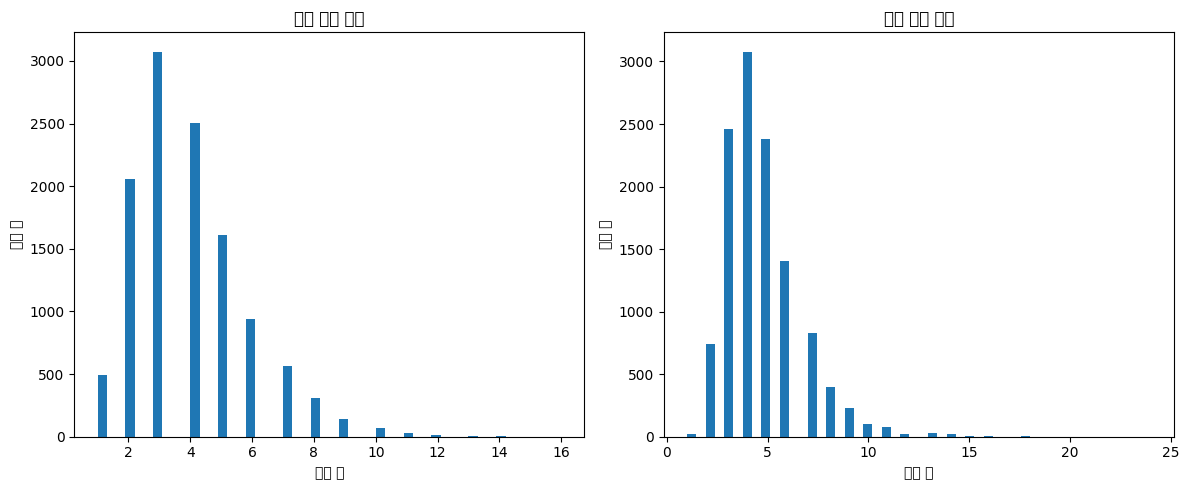

질문 데이터 개수 : 11823
답변 데이터 개수 : 11823


In [7]:
# 특수 문자 제거 함수
def preprocess_sentence(sentence):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

# 질문과 답변 데이터 전처리
questions = data['Q'].apply(preprocess_sentence).tolist()
answers = data['A'].apply(preprocess_sentence).tolist()

print('전처리 후의 22번째 질문 샘플:', questions[21])
print('전처리 후의 22번째 답변 샘플:', answers[21])

# 질문과 답변의 최대 길이 확인
print('질문의 최대 길이 :', max(len(question.split()) for question in questions))
print('답변의 최대 길이 :', max(len(answer.split()) for answer in answers))

# 데이터의 분포 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist([len(question.split()) for question in questions], bins=50)
plt.title('질문 길이 분포')
plt.xlabel('단어 수')
plt.ylabel('문장 수')

plt.subplot(1, 2, 2)
plt.hist([len(answer.split()) for answer in answers], bins=50)
plt.title('답변 길이 분포')
plt.xlabel('단어 수')
plt.ylabel('문장 수')

plt.tight_layout()
plt.show()

# 데이터 크기 제한 (선택사항)
MAX_SAMPLES = 50000
questions = questions[:MAX_SAMPLES]
answers = answers[:MAX_SAMPLES]

print('질문 데이터 개수 :', len(questions))
print('답변 데이터 개수 :', len(answers))

Step 3. SubwordTextEncoder 사용하기

한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.



In [8]:
import tensorflow_datasets as tfds

# SubwordTextEncoder를 사용하여 텍스트를 토큰화하고 인코딩
def tokenize_and_filter(inputs, outputs, max_length):
    tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
        inputs + outputs, target_vocab_size=2**13)

    # 시작 토큰과 종료 토큰 정의
    START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

    # 토큰화 및 패딩
    tokenized_inputs, tokenized_outputs = [], []
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        if len(sentence1) <= max_length and len(sentence2) <= max_length:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=max_length, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=max_length, padding='post')

    return tokenized_inputs, tokenized_outputs, tokenizer

# 최대 문장 길이 설정 (이전 단계의 분석 결과를 바탕으로 설정)
MAX_LENGTH = 40

# 토큰화 및 패딩 적용
questions_tok, answers_tok, tokenizer = tokenize_and_filter(questions, answers, MAX_LENGTH)

# 어휘 사이즈 (시작 토큰과 종료 토큰 포함)
VOCAB_SIZE = tokenizer.vocab_size + 2
print('어휘 사이즈 :', VOCAB_SIZE)

# 토큰화된 데이터 샘플 출력
print('토큰화된 질문 (샘플):', questions_tok[0])
print('토큰화된 답변 (샘플):', answers_tok[0])

# 디코딩 예시
def decode_sequence(sequence):
    return tokenizer.decode([i for i in sequence if i < tokenizer.vocab_size])

print('디코딩된 질문 (샘플):', decode_sequence(questions_tok[0]))
print('디코딩된 답변 (샘플):', decode_sequence(answers_tok[0]))

# 데이터셋 생성
BATCH_SIZE = 32
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions_tok,
        'dec_inputs': answers_tok[:, :-1]
    },
    answers_tok[:, 1:]
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

print("데이터셋이 수정되었습니다.")
print("데이터셋 크기:", len(list(dataset)))

어휘 사이즈 : 8129
토큰화된 질문 (샘플): [8127 4188 3045   42 8128    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
토큰화된 답변 (샘플): [8127 3831   74 7861    1 8128    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
디코딩된 질문 (샘플): 시 땡 !
디코딩된 답변 (샘플): 하루가 또 가네요 .
데이터셋이 수정되었습니다.
데이터셋 크기: 370


Step 4. 모델 구성하기

위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.



Step 4-1: 포지셔널 인코딩과 스케일드 닷 프로덕트 어텐션


In [9]:
import numpy as np
import tensorflow as tf

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            np.arange(position)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model
        )

        # 짝수 인덱스에는 sin 적용
        sines = np.sin(angle_rads[:, 0::2])
        # 홀수 인덱스에는 cos 적용
        cosines = np.cos(angle_rads[:, 1::2])

        pos_encoding = np.concatenate([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        # SparseTensor을 DenseTensor로 변환
        if isinstance(inputs, tf.SparseTensor):
            inputs = tf.sparse.to_dense(inputs)
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super().get_config()
        config.update({
            "position": self.pos_encoding.shape[1],
            "d_model": self.pos_encoding.shape[2]
        })
        return config

def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    if mask is not None:
        logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(logits, axis=-1)
    output = tf.matmul(attention_weights, value)

    return output

print("scaled_dot_product_attention 함수가 수정되었습니다.")

print("포지셔널 인코딩과 스케일드 닷 프로덕트 어텐션 함수가 정의되었습니다.")

scaled_dot_product_attention 함수가 수정되었습니다.
포지셔널 인코딩과 스케일드 닷 프로덕트 어텐션 함수가 정의되었습니다.


Step 4-2: 멀티헤드 어텐션 레이어


In [10]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        outputs = self.dense(concat_attention)

        return outputs

    def compute_output_shape(self, input_shape):
        return input_shape['query'][:-1] + (self.d_model,)

    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads
        })
        return config

print("멀티헤드 어텐션 레이어가 수정되었습니다.")

멀티헤드 어텐션 레이어가 수정되었습니다.


Step 4-3: 인코더 레이어


In [11]:

def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)



def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    positional_encoding = PositionalEncoding(vocab_size, d_model)
    embeddings = positional_encoding(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name=f"encoder_layer_{i}",
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

print("인코더 레이어와 전체 인코더가 정의되었습니다.")

인코더 레이어와 전체 인코더가 정의되었습니다.


Step 4-4: 디코더 레이어


In [12]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

print("디코더 레이어가 정의되었습니다.")

디코더 레이어가 정의되었습니다.


Step 4-5: 전체 디코더


In [13]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name=f'decoder_layer_{i}',
        )([outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)
print("전체 디코더가 정의되었습니다.")

전체 디코더가 정의되었습니다.


Step 4-6: 트랜스포머 모델


In [14]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

print("트랜스포머 모델 함수가 수정되었습니다.")

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    return mask[tf.newaxis, tf.newaxis, :, :]  # (1, 1, seq_len, seq_len)

print("트랜스포머 모델 함수가 수정되었습니다.")

트랜스포머 모델 함수가 수정되었습니다.
트랜스포머 모델 함수가 수정되었습니다.


Step 4-7: 모델 인스턴스화 및 학습 설정


In [15]:
# 하이퍼파라미터 설정
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

print("CustomSchedule 클래스가 수정되었습니다.")


def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred[:, :-1, :], from_logits=True)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred[:, :-1, :])

print("손실 함수와 정확도 함수가 수정되었습니다.")

# 학습률 조정
learning_rate = CustomSchedule(D_MODEL)
learning_rate.warmup_steps = 8000  # 웜업 스텝 증가

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# 모델 재컴파일
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

print("모델이 다시 컴파일되었습니다.")

CustomSchedule 클래스가 수정되었습니다.
손실 함수와 정확도 함수가 수정되었습니다.
모델이 다시 컴파일되었습니다.


Step 5: 모델 훈련 및 평가


Epoch 1/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.0125 - loss: 1.5038

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


370/370 ━━━━━━━━━━━━━━━━━━━━ 117s 144ms/step - accuracy: 0.0126 - loss: 1.5036
Epoch 2/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0277 - loss: 1.2043
Epoch 3/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0462 - loss: 1.0000
Epoch 4/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0578 - loss: 0.9050
Epoch 5/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0719 - loss: 0.7792
Epoch 6/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0889 - loss: 0.6291
Epoch 7/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1072 - loss: 0.4885
Epoch 8/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1255 - loss: 0.3680
Epoch 9/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1447 - loss: 0.2605
Epoch 10/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1592 - loss: 0.1778
Epoch 11/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1654 - loss: 0.1122
Epoch 12/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accu

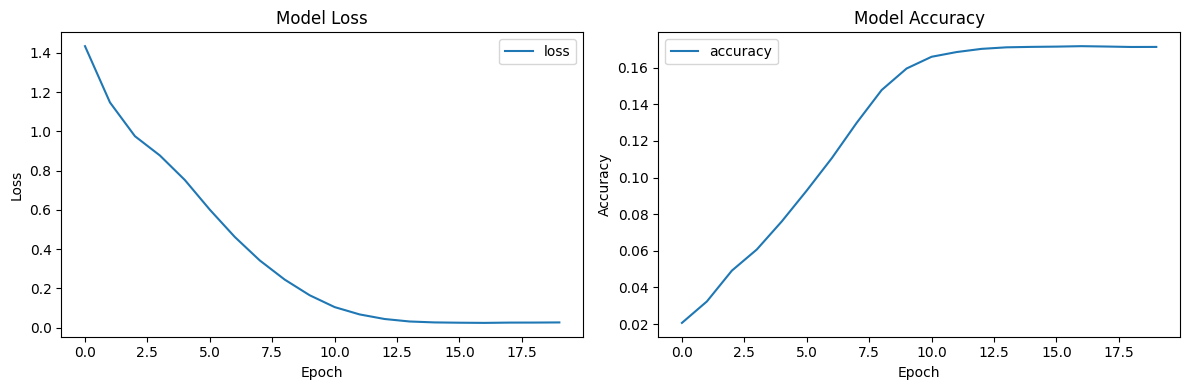

모델 훈련이 완료되었습니다.


In [16]:
EPOCHS = 20

# 체크포인트 설정
checkpoint_path = "./checkpoints/train.weights.h5"

ckpt = tf.train.Checkpoint(transformer=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 체크포인트가 있으면 최신 체크포인트를 복원
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

# 모델 재학습
history = model.fit(
    dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(
            filepath="./checkpoints/best_model.weights.h5",
            save_weights_only=True,
            save_best_only=True,
            monitor='loss'
        )
    ]
)

print("모델 재학습이 완료되었습니다.")

# 훈련 결과 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print("모델 훈련이 완료되었습니다.")

Step 5. 모델 평가하기

Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.



In [19]:
def predict_response(input_sentence):
    # 입력 문장 전처리
    input_sentence = preprocess_sentence(input_sentence)

    # 입력 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 추가
    input_sequence = START_TOKEN + tokenizer.encode(input_sentence) + END_TOKEN
    input_sequence = tf.expand_dims(input_sequence, 0)

    # 출력 시퀀스 초기화
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[input_sequence, output_sequence], training=False)

        # 다음 토큰 예측
        predicted_id = tf.cast(tf.argmax(predictions[:, -1:, :], axis=-1), tf.int32)

        # 예측된 토큰을 출력 시퀀스에 추가
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

        # 종료 토큰이 예측되면 루프 종료
        if predicted_id == END_TOKEN:
            break

    # 예측된 시퀀스를 디코딩하여 문장으로 변환
    predicted_sentence = tokenizer.decode(
        [i for i in output_sequence[0] if i < tokenizer.vocab_size]
    )

    return predicted_sentence

# 모델 평가
def evaluate_model():
    test_sentences = [
        "안녕하세요",
        "오늘 날씨가 어때요?",
        "기분이 좋아요",
        "영화 보러 갈까요?",
        "맛있는 음식 추천해주세요"
    ]

    print("모델 평가 결과:")
    for sentence in test_sentences:
        response = predict_response(sentence)
        print(f"입력: {sentence}")
        print(f"출력: {response}")
        print()

# 모델 평가 실행
evaluate_model()

모델 평가 결과:
입력: 안녕하세요
출력: 안녕하세요

입력: 오늘 날씨가 어때요?
출력: 오늘 날씨가 어때요 ?

입력: 기분이 좋아요
출력: 기분이 좋아요

입력: 영화 보러 갈까요?
출력: 영화 보러 힘들거예요요 ?

입력: 맛있는 음식 추천해주세요
출력: 맛있는 음식 추천해주세요



# 회고

- LMS6 학습부터 코드를 작성하는 것 보다 전체 흐름을 이해하는 것이 우선 급선무였습니다.
- 클래스내 함수와 다른 클래스의 함수간의 관계 및 함수 호출의 구조를 이해하기에 난이도가 꽤 있었습니다.
- 아직도 설명하라고 하면 쉽지 않을 것 같습니다.
- 클로드의 도움을 받아서 에러를 수정하다보니 기능을 보완하다가 규모가 더 커졌습니다.
- 질문에 대한 답변이 올바르게 이루어 지지 않았습니다. 구조상 어디가 문제인지는 아직 알 수 없습니다.
- 안정감 있게 구조를 이해한 이후에 필수적인 코드를 작성하고 코드 오류를 수정하는 것이 가능할 것 같습니다.
- 실용적인 챗봇에 비하면 난이도가 낮은 편이겠지만 제 상황에 걸맞는 프로그램 훈련이 필요해보입니다.
- 다시 학습하고 오류 없도록 수정하는 동안 건강한 스트레스가 좋은 영향을 미친 것 같습니다.